<div class="title">Practical Assignment: Support Vector Machines</div>
<div class="subtitle">Métodos Avanzados en Aprendizaje Automático</div>
<div class="author">Marlon Rodríguez Flor</div>

---

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [1]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used (all of them quite standard except for `utils`, which is provided with the notebook).

In [3]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from utils import plot_dataset_clas, plot_svc

matplotlib.rc('figure', figsize=(15, 5))
seed = 123

2023-11-22 13:01:47.213703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 13:01:47.296223: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-22 13:01:47.314766: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 13:01:47.943696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

# Introduction

This practical assignment consists in implementing a simplified version of the SVC class of `scikit-learn`.

This class will contain two fundamentals routines, one for training a non-linear SVC (using the RBF kernel), based on the SMO algorithm for solving the dual optimization problem, and the other one for predicting over new out-of-sample points.

# SMO Algorithm

## Optimization Problem

The dual optimization problem for the Soft-Margin SVM is:
$$
 \left \{ \begin{array}{l} \min_{\boldsymbol{\alpha} \in \mathbb{R}^N} \frac{1}{2} \boldsymbol{\alpha}^\intercal \tilde{\mathbf{K}} \boldsymbol{\alpha} - \boldsymbol{\alpha}^\intercal \mathbf{1} \\ \text{ s.t. } \boldsymbol{\alpha}^\intercal \mathbf{y} = 0 , 0 \le \boldsymbol{\alpha} \le C ,
 \end{array} \right .
$$
where $\tilde{k}_{ij} = y_i y_j \mathcal{K}(\mathbf{x}_i, \mathbf{x}_j)$.

This optimization problem is a QP problem, which is usually solved using an *ad hoc* algorithm: Sequential Minimal Optimization (SMO).

## SMO and Coordinate Descent

The main idea behind SMO is that the optimization problem is too involved to be solved as a whole, but it can be largely simplified considering only a few variables at a time.
In this divide-and-conquer approach, called coordinate descent, the objective function is iteratively minimized over the different variables.

In particular, SMO deals with two variables, the smaller working group that can be modified while respecting the constraints.
Formally, the algorithm updates the current $\alpha^\text{old}_i$ and $\alpha^\text{old}_j$ coefficients to some new values $\alpha_i$ and $\alpha_j$, assuming that $\boldsymbol{\alpha}^\text{old}$ satisfies $(\boldsymbol{\alpha}^\text{old})^\intercal \mathbf{y} = 0$. In order to keep respecting the constraint in the new estimation, the following equation needs to be fulfilled:
\begin{align*}
 & y_i \alpha^\text{old}_i + y_j \alpha^\text{old}_j = y_i \alpha_i + y_j \alpha_j \\
 &\implies y_i (\alpha_i - \alpha^\text{old}_i) = - y_j (\alpha_j - \alpha^\text{old}_j) \\
 &\implies \alpha_i = \alpha^\text{old}_i - y_i y_j (\alpha_j - \alpha^\text{old}_j) .
\end{align*}

For simplicity, one can assume that the update for the $j$-th coefficient is given by $\alpha_j = \alpha^\text{old}_j + d$, and hence the optimization problem becomes a simple one-dimensional minimization.
Therefore, it can be solved by computing the derivative with respect to $d$ and equating to $0$.
After some derivations, the optimum unconstrained update turns out to be:
\begin{align*}
 d &= \frac{y_j (E(\mathbf{x}_j, y_j) - E(\mathbf{x}_i, y_i))}{\kappa} , \text{ where} \\
 \kappa &= 2 \mathcal{K}(\mathbf{x}_i, \mathbf{x}_j) - \mathcal{K}(\mathbf{x}_i, \mathbf{x}_i) - \mathcal{K}(\mathbf{x}_j, \mathbf{x}_j) , \text{ and} \\
 E(\mathbf{x}, y) &= \sum_{i = 1}^N \alpha^\text{old}_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) - y .
\end{align*}

## Clipping

The previous update does not take into account the box constrains $0 \le \alpha_i, \alpha_j \le C$.
In order to satisfy these constraints for both $\alpha_i$ and $\alpha_j$, $\alpha_j$ has to be clipped to the interval $[L, H]$, where
$$
 \begin{cases}
  L = \max(0, \alpha^\text{old}_j - \alpha^\text{old}_i), & H = \min(C, C - \alpha^\text{old}_i + \alpha^\text{old}_j) & \text{if } y_i \neq y_j , \\
  L = \max(0, \alpha^\text{old}_j + \alpha^\text{old}_i - C), & H = \min(C, \alpha^\text{old}_i + \alpha^\text{old}_j) & \text{if } y_i = y_j .
 \end{cases}
$$

Therefore, the update for $\alpha_j$ becomes:
$$ \alpha_j = \min(\max(\alpha^\text{old}_j + d, L), H) , $$
and, as mentioned above, the corresponding update for $\alpha_i$ is:
$$ \alpha_i = \alpha^\text{old}_i - y_i y_j (\alpha_j - \alpha^\text{old}_j) . $$

## Selecting the Working Pair

There are different methods for selecting the working pair of coefficients $(i, j)$ that will be updated.
Usually, first or second order information is used to choose the working set, trying to find those that will provide the largest minimization of the objective function.

Nevertheless, in this work a simplified version of SMO will be implemented.
The first coefficient $i$ will be selected just iteratively, cycling over all the possible values $i = 1, 2, \dotsc, N$. The second coefficient $j$ is selected randomly over the remaining possible values $j \neq i$.

It should be noted that this approach will not guarantee the convergence in general, since not all possible pairs $(i, j)$ are explored, but it will work in most problems.

## Stopping Criteria

The algorithm will be terminated when a certain maximum number of iterations is reached (for each iteration, all the coefficients are updated), or when after one iteration the total change of the coefficients is smaller than a certain tolerance, $\| \boldsymbol{\alpha} - \boldsymbol{\alpha}^\text{old}\| < \epsilon$.

Since the working pair is generated randomly, it can happen that after a whole iteration the changes are smaller than $\epsilon$ not because the optimization is finished, but because of "bad luck". A workaround is to set $\epsilon = 0$ to force all the iterations.

## Computing the Intercept

Once the optimum dual coefficients $\boldsymbol{\alpha}^*$ have been estimated, the intercept $b^*$ can be computed knowing that any support vector $\mathbf{x}_k$ with $0 < \alpha^*_k < C$ satisfies:
$$ b^* = y_k - \sum_{i = 1}^N \alpha^*_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}_k) . $$

This equality is usually averaged over all the possible vectors $k$ satisfying $0 < \alpha^*_k < C$ for reasons of numerical stability.

## Prediction

Once the model is trained and the optimal parameters $\boldsymbol{\alpha}^*$ and $b^*$ are known, the score predicted over a new sample $\mathbf{x}$ is:
$$ f(\mathbf{x}) = \sum_{i = 1}^N \alpha^*_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) + b . $$

Finally, the class is assigned with:
$$ \hat{y} = \operatorname{sign}(f(\mathbf{x})) . $$

# Implementation of the SVC

## Requirements

The objective of this assignment is to complete the class `MySVC` sketched below, which should contain at least the following methods.

---
```python
__init__(self, C=1.0, gamma="scale", tol=0.0001, max_iter=10000)
```
* This is the construction method for the class, with the following parameters:
    * `C`: Regularization parameter $C$ of the SVC.
    * `gamma`: Kernel parameter $\gamma$ of the RBF kernel.
    * `tol`: Tolerance for the stopping criterion $\epsilon$.
    * `max_iter`: Maximum number of iterations (in the sense of epochs, each iteration contains a pass through all the coefficients).
* This method should only store the parameters in fields of the class, to be used when needed.

---
```python
fit(self, X, y)
```
* This is the training method, with the following parameters:
    * `X`: Training data matrix $\mathbf{X} \in \mathbb{R}^{N \times d}$.
    * `y`: Vector of labels $\mathbf{y}$, with $y_i \in \{-1, +1\}$.
* This method should solve the dual optimization problem, storing the obtained coefficients and other useful information in fields of the class.

---
```python
decision_function(self, X)
```
* This is the method that computes the output of the SVC, with the following parameters:
    * `X`: Test data matrix $\mathbf{X}' \in \mathbb{R}^{N' \times d}$.
* This method should predict the output (the score) of the SVC, using the information stored in the fields of the class, and return it as a vector

---
```python
predict(self, X)
```
* This is the method that computes the predicted class of the SVC, with the following parameters:
    * `X`: Test data matrix $\mathbf{X}' \in \mathbb{R}^{N' \times d}$.
* This method should predict the assigned class of the SVC, using the information stored in the fields of the class, and return it as a vector.

## Recommendations

Additional auxiliary methods can be defined to simplify the code.
Some suggestions are:

1. A method to compute the output of the SVC, with the current estimated parameters but without considering the intercept:
$$ \sum_{i = 1}^N \alpha_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) . $$
1. A method to compute $E(\mathbf{x}, y)$.
1. A method to compute the lower and upper bounds $L$ and $H$ for the clipping of the update.
1. A method to estimate $b^*$.

## Implementation

<div class="qst">

* Complete the `MySVC` class below, satisfying the described requirements.

</div>

In [4]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

class MySVC():
    """
        SVC with a simplified version of SMO.
    """
    def __init__(self, C=1.0, gamma="scale", tol=0.0001, max_iter=100):
        # Assignment of the hyper-parameters (complete).
        self.C = C
        self.gamma = gamma
        self.tol = tol
        self.max_iter = max_iter
        self.kernel = 'rbf'

        # Computed parameters
        self.a = None
        self.support_ = None
        self.support_vectors_ = None
        self.coef_ = None
        self.intercept_ = None
        

    def fit(self, X, y):
        # Constants.
        n_pat = X.shape[0]
        n_dim = X.shape[1]

        # Options for gamma (for compatibility with sklean).
        if (self.gamma == "scale"):
            self.gamma = 1.0 / (n_dim * X.var())
        if (self.gamma == "auto"):
            self.gamma = 1.0 / n_dim

        # Initialization of the dual coefficients (named "a" instead of "alpha" for simplicity).
        self.a = np.zeros(n_pat)

        # Other initializations (complete).
        K = rbf_kernel(X, gamma=self.gamma)

        # Loop over the iterations.
        for it in range(self.max_iter):
            # Initializations (complete).
            a_old = self.a

            # Loop over the coefficients.
            for i in range(0, n_pat):
                j = self.choose_j(i)

                # Update of the corresponding a[i] and a[j] values (complete).
                k_ = 2*K[i,j] - K[i,i] - K[j,j]
                d = (y[j] * (self.compute_E(y, K, j) - self.compute_E(y, K, i)))/k_
                L,H = self.compute_LH(y, i, j)
                a_old = self.a[j]
                self.a[j] = min(max(a_old + d, L),H)
                self.a[i] = self.a[i] - y[i]*y[j]*(self.a[j] - a_old)
                
            # Check of the stopping conditions (complete).
            if np.linalg.norm(self.a - a_old) < self.tol:
                break

        # Storage of the obtained parameters and computation of the intercept (complete).
        self.support_ = np.where(self.a > 0)[0]
        self.support_vectors_ = X[self.a > 0]
        self.dual_coef_ = (y*self.a)[self.a > 0]
        self.intercept_ = self.compute_intercept(K,y,(self.a > 0) & (self.a < self.C))
        
        return self

    def decision_function(self, X):
        # Computation of the decision function over X (complete).
        return np.dot(self.dual_coef_, rbf_kernel(self.support_vectors_, X, gamma=self.gamma)) + self.intercept_

    def predict(self, X):
        # Computation of the predicted class over X (complete).
        return np.sign(self.decision_function(X))

    # Auxiliary methods (complete if needed).
    def choose_j(self, i):
        v = np.arange(len(self.a))
        return np.random.choice(v[v != i])

    # ...

    def compute_LH(self, y, i, j):
        L,H = None, None
        if y[i] != y[j]:
            L = max(0, self.a[j] - self.a[i])
            H = min(self.C, self.C - self.a[i] + self.a[j])
        else:
            L = max(0, self.a[j] + self.a[i] - self.C)
            H = min(self.C, self.a[i] + self.a[j])
        return L,H

    def compute_E(self, y, K, i):
        return self.compute_output(y, K, i) -  y[i]
    
    def compute_output(self, y, K, i):
        return np.dot(self.a * y, K[:,i])
    
    def compute_intercept(self, K, y, xk):
        return np.mean([y[i] - self.compute_output(y,K,i) for i in  np.where(xk)[0]])
        

# Experiments with the SVC

## Comparative with `scikit-learn`

The following cell generates the *moons* dataset, dividing it into train and test splits, and depicting it.

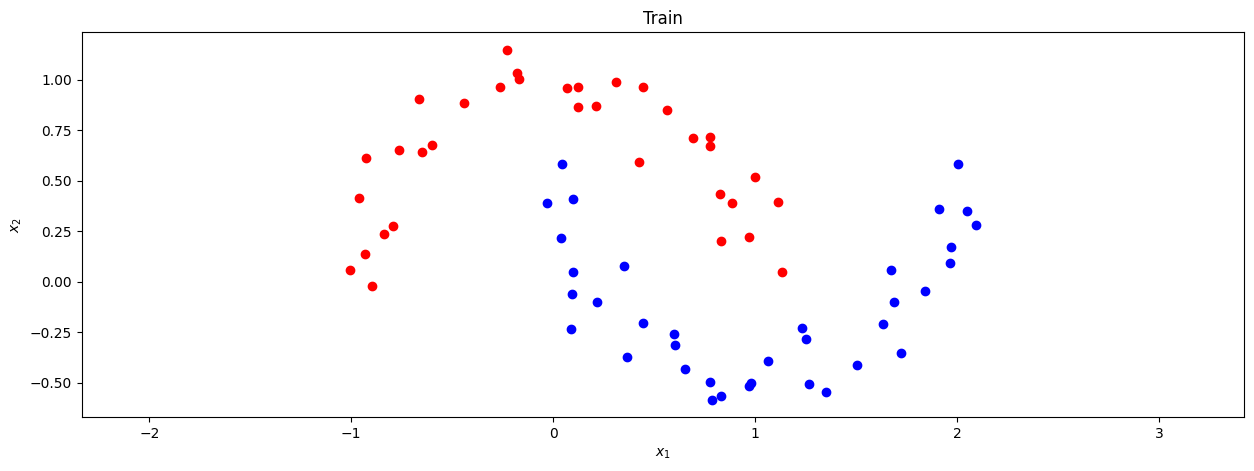

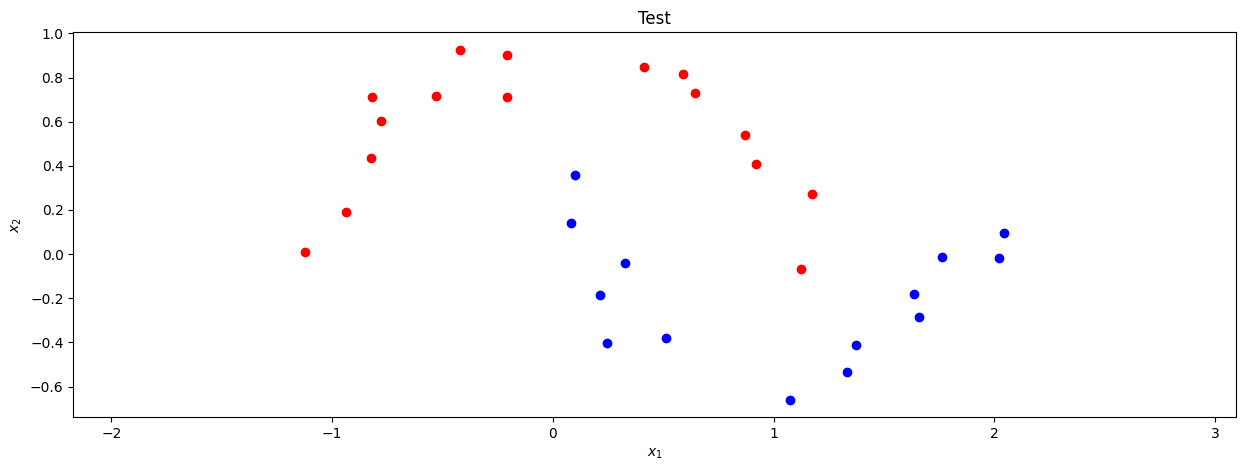

In [5]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score

x, y = make_moons(noise=1e-1, random_state=seed)
y[y != 1] = -1

x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.3, random_state=seed)

plot_dataset_clas(x_tr, y_tr)
plt.title('Train'); plt.show()
plot_dataset_clas(x_te, y_te)
plt.title('Test'); plt.show()

<div class="qst">

* Train an SVC model over the training data (`x_tr`, `y_tr`), using both the `SVC` class of `scikit-learn` and the implemented `MySVC` class.
* Predict using the previous two models over the test data (`x_te`, `y_te`).
* Compare that both classes provide the same outputs (in terms of the decision function and of the predicted class), describing the obtained results.
  If needed, reduce the default stopping tolerance and/or increase the default maximum number of iterations.

</div>

In [6]:
C = 1
gamma = 'scale'

model_my = MySVC(C=C, gamma=gamma)
model_sk = SVC(C=C, gamma=gamma)

# Training of the models (complete).
model_my.fit(x_tr, y_tr)
model_sk.fit(x_tr, y_tr)

# Comparative of the predicted scores (complete).
score_sk = model_sk.decision_function(x_te)
score_my= model_my.decision_function(x_te)

print('1. Comparación Scores Función de Decisión:\n  - Son Iguales: %s\n  - Son Similares (abs(diff) < 0.05): %s'%
      ((score_sk == score_my).all(), (np.abs(score_sk - score_my) <= 0.05).all()))

# Comparative of the predicted classes (complete).
pred_sk = model_sk.predict(x_te)
pred_my = model_my.predict(x_te)

print('2. Comparación Clases Predecidas:\n  - Son Iguales: %s'%((pred_sk == pred_my).all()))

print('3. Métricas:\n  - Implementación Sklearn:\n\t- acc: %f\n\t- auc: %f\n  - Implementación My(Propia):\n\t- acc: %f\n\t- auc: %f'
      %(accuracy_score(y_te, pred_sk), roc_auc_score(y_te, score_sk), accuracy_score(y_te, pred_my), roc_auc_score(y_te, score_my)))


1. Comparación Scores Función de Decisión:
  - Son Iguales: False
  - Son Similares (abs(diff) < 0.05): True
2. Comparación Clases Predecidas:
  - Son Iguales: True
3. Métricas:
  - Implementación Sklearn:
	- acc: 0.966667
	- auc: 0.995536
  - Implementación My(Propia):
	- acc: 0.966667
	- auc: 0.995536


- **Análisis de Comparación de los scores obetenidos en la función de decisión:**
    - El el punto 1 anterior se compara los resultados de la implementación de Sklearn y la de este documento. Al comparar si los resultados de cada implementación son iguales obtenemos un falso, esto se debe a que los parámetros (alphas, b, etc) escogidos en las iteracaiones e hiperparámetros del modelo no son necesariamente iguales a la implementación de Sklearn, sin embargo, sí son similares con una toleracia determinda (en este caso 0.05). 
- **Análisis de Comparación de las clases predecidas:**
    - Al comparar las etiquetas predecidas por el modelo se observa que son exactamente iguales, a pesar de que los valores obtenidos en la función de decisión no lo sean. Esto se debe a que los parámetros escogidos al realilzar el SMO son igualmente "buenos" lo que permite realizar una buena predicción como se observa en el punto 3 de métricas.
- A continuación, se realiza una comparación gráfica con los datos de entrenamineto y prueba, utilizando la función *plot_svc* implementada en *utils.py*. 

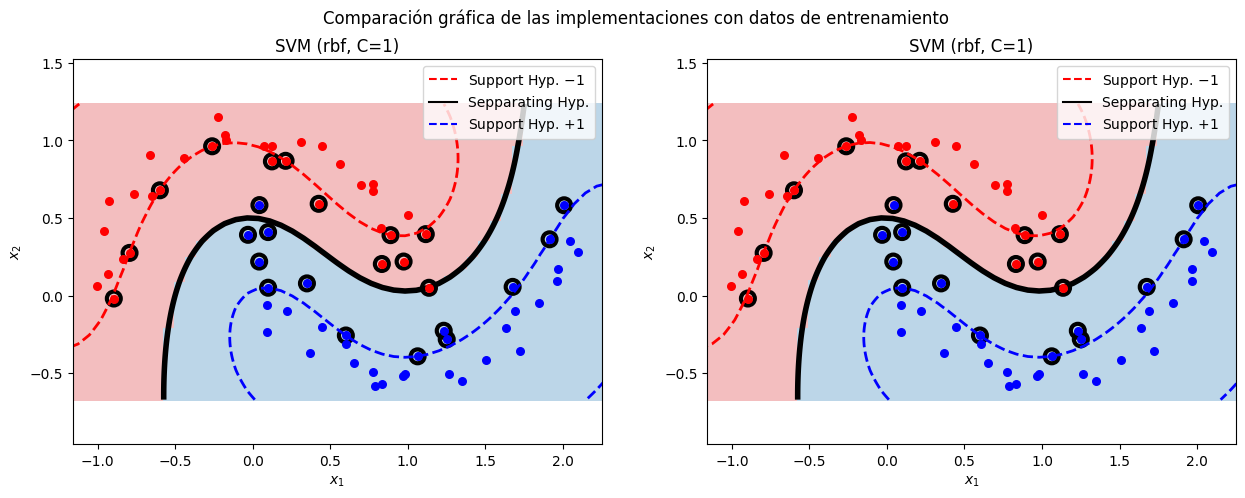

In [7]:

plt.suptitle('Comparación gráfica de las implementaciones con datos de entrenamiento')
plt.subplot(1, 2, 1)
plot_svc(x_tr, y_tr, model_sk) # Sklearn


plt.subplot(1, 2, 2)
plot_svc(x_tr, y_tr, model_my) # Propio
plt.show()

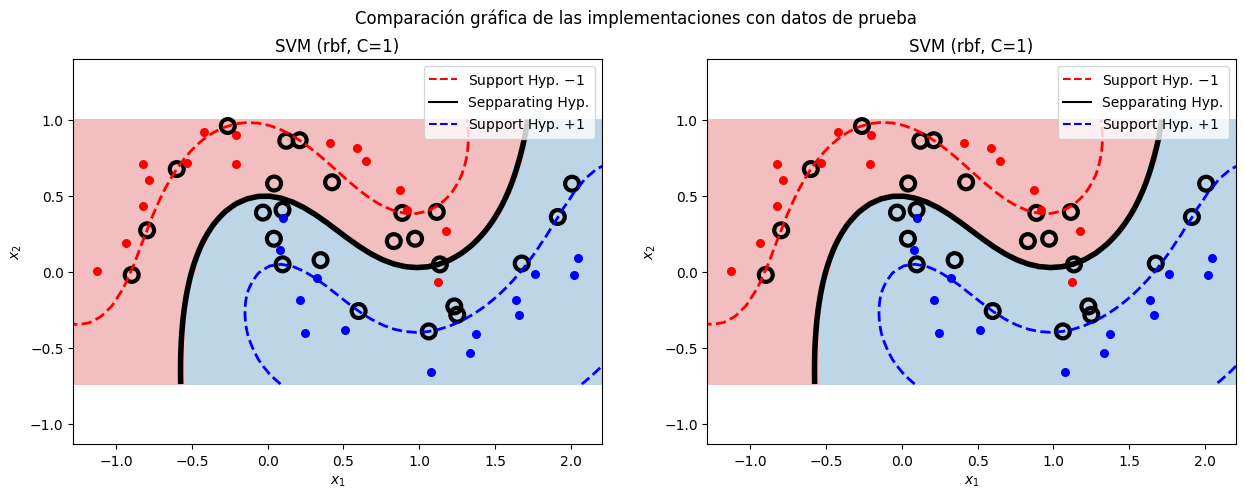

In [8]:
plt.suptitle('Comparación gráfica de las implementaciones con datos de prueba')
plt.subplot(1, 2, 1)
plot_svc(x_te, y_te, model_sk) # Sklearn

plt.subplot(1, 2, 2)
plot_svc(x_te, y_te, model_my) # Propio
plt.show()

## Understanding the SVM

<div class="qst">

* Considering the model created with the `MySVC` class:
    * Extract the list of support vectors, explaining the followed approach.
    * Extract the list of training points bad and well classified, explaining the followed approach.
    * Extract the list of training points that lie over the supporting hyperplanes.
    * Extract the list of training points located on the wrong side of the supporting hyperplanes, but that are well classified.
* What are the conditions over the dual coefficients $\alpha_i$ that characterize the previous lists (if any)?

</div>

In [9]:
# Extraction of the lists (complete).

# Support Vectors
print('1. Vectores de Soporte:\n\t- Número de VS: %i\n\t- Índices VS: %s\n\t- VS:%s'%(len(model_my.support_),model_my.support_, model_my.support_vectors_))

1. Vectores de Soporte:
	- Número de VS: 25
	- Índices VS: [ 1  2  3  6  8  9 19 20 24 26 27 31 35 37 39 43 44 50 52 53 55 57 62 66
 69]
	- VS:[[-0.7952664   0.2746645 ]
 [ 0.59973944 -0.25787141]
 [ 0.9720389   0.21902698]
 [ 0.09841814  0.05019174]
 [ 0.42448524  0.59130712]
 [ 1.06252195 -0.39226767]
 [ 0.88775478  0.38926482]
 [ 1.23082636 -0.22735139]
 [ 1.115151    0.39583904]
 [ 0.12278879  0.8649236 ]
 [ 1.13567114  0.04975262]
 [ 1.67526518  0.05558455]
 [ 0.21104358  0.86864391]
 [-0.59960441  0.67856403]
 [-0.26285754  0.96232495]
 [ 0.0423632   0.58312272]
 [-0.03147581  0.39140976]
 [ 1.25022826 -0.2826266 ]
 [ 2.00729148  0.58188871]
 [ 0.04062784  0.21890576]
 [ 0.83174596  0.20326404]
 [ 1.91345677  0.3625312 ]
 [ 0.09781582  0.4090848 ]
 [-0.89675203 -0.01943427]
 [ 0.34875151  0.07811214]]


- Para obtener los vectores de soporte se llama al atributo *support_* el cual contiene los índices de los vectores de soporte. Para obtener los índices de los vectores de soporte simplemente se toman las alphas con la condición de que sean mayores a cero y filtramos los puntos en X.

In [10]:
# Classification
pred_my_train = model_my.predict(x_tr)
well_classified =  np.where(pred_my_train == y_tr)[0] 
bad_classified =  np.where(pred_my_train != y_tr)[0] 

print('2. Clasificación de Puntos:\n\t- Bien Clasificados:\n\t\t- Número: %i\n\t\t- Índice de Puntos: %s\n\t- Mal Clasificados:\n\t\t- Número: %i\n\t\t- Índice de Puntos: %s'%
      (len(well_classified), well_classified,len(bad_classified), bad_classified))

2. Clasificación de Puntos:
	- Bien Clasificados:
		- Número: 68
		- Índice de Puntos: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
	- Mal Clasificados:
		- Número: 2
		- Índice de Puntos: [27 43]


- Para obtener los puntos que se encuentran bien y mal clasificados en los datos de entrenamiento, se toma la predicción de las etiquedas y se compara con las etiquetas reales de los datos. Los puntos donde las etiquetas coinciden se encuentran bien clasificados, caso contrario el punto esta mal clasificado.

In [11]:
# Points over Support Vectors Hyperplane
points_over_svh = np.where((model_my.a > 0) & (model_my.a < C))[0]

print('3. Puntos sobre el hiperplano de VS:\n\t- Número: %i\n\t- Índices: %s\n\t- Puntos: %s'%(len(points_over_svh), points_over_svh, x_tr[points_over_svh,:]))


3. Puntos sobre el hiperplano de VS:
	- Número: 9
	- Índices: [ 1  2  6  9 19 35 37 39 57]
	- Puntos: [[-0.7952664   0.2746645 ]
 [ 0.59973944 -0.25787141]
 [ 0.09841814  0.05019174]
 [ 1.06252195 -0.39226767]
 [ 0.88775478  0.38926482]
 [ 0.21104358  0.86864391]
 [-0.59960441  0.67856403]
 [-0.26285754  0.96232495]
 [ 1.91345677  0.3625312 ]]


- Para obterner los vectores de soporte que caen en el hiperplano nuevamente utililzamos la alphas obtenidas en el entrenamiento del modelo. En este caso se toman las alphas que cumplan la condición $0 < \alpha < C$ y filtramos de acuerdo al índice de X.

In [12]:
# Points in the wrong side of the supporting hyperplane and well classified
points_incorrect_side = [i in well_classified for i in np.where((model_my.a == C))[0]]
points_incorrect_side_well_class = np.where((model_my.a == 1))[0][points_incorrect_side]
points_incorrect_side_well_class

print('4. Puntos bien clasificados en el lado contrario al hiperplano de soporte:\n\t- Número: %i\n\t- Índice: %s\n\t- Puntos: %s'%
      (len(points_incorrect_side_well_class),points_incorrect_side_well_class, x_tr[points_incorrect_side_well_class]))

4. Puntos bien clasificados en el lado contrario al hiperplano de soporte:
	- Número: 14
	- Índice: [ 3  8 20 24 26 31 44 50 52 53 55 62 66 69]
	- Puntos: [[ 0.9720389   0.21902698]
 [ 0.42448524  0.59130712]
 [ 1.23082636 -0.22735139]
 [ 1.115151    0.39583904]
 [ 0.12278879  0.8649236 ]
 [ 1.67526518  0.05558455]
 [-0.03147581  0.39140976]
 [ 1.25022826 -0.2826266 ]
 [ 2.00729148  0.58188871]
 [ 0.04062784  0.21890576]
 [ 0.83174596  0.20326404]
 [ 0.09781582  0.4090848 ]
 [-0.89675203 -0.01943427]
 [ 0.34875151  0.07811214]]


- Finalmente, para tomar los puntos que están bien clasificados y que están del lado contrario al hiperplano de los vectores de soporte tomamos en cuenta dos 2 condiciones:
    - Escogemos los alphas iguales a C ($\alpha = C$) y obtenemos los puntos de X que complen esta condición.
    - Además, de los puntos anteriores filtramos los que están bien clasificados que obtuvimos anteriormente.